In [ ]:
# load and modify the data 
# for all data in gyro 

import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

frames = []
threshold = 80
file_index = "0071"
index_avg = 18
bs = 10


file_name = f"gyro_data/gyro_data_{file_index}.txt"


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=1):

    # convert to integer
    serial_data = ast.literal_eval(data)

    print(serial_data)

    # Define a regular expression pattern to match valid strings
    valid_pattern = re.compile(r'^-?\d+$')  

    # Filter out entries with invalid strings or empty strings
    filtered_data = [row for row in serial_data if all(valid_pattern.match(value.strip()) for value in row) and all(value.strip() for value in row)]

    # Check each entry for the correct number of values
    incorrect_entries = []
    for index, entry in enumerate(filtered_data):
        if len(entry) != expected_length:
            print(f"Entry at index {index} has {len(entry)} values instead of {expected_length}.")
            incorrect_entries.append(index)
    
    # Remove entries with incorrect number of values
    for index in sorted(incorrect_entries, reverse=True):
        del filtered_data[index]
    
    stripped_data = [[int(value.strip()) for value in row] for row in filtered_data]  

    # transpose the data 
    transposed_data = list(map(list, zip(*stripped_data)))   

    return transposed_data

def determine_laser(mod_data):
    laser_state = []

    # such that all minima are found
    for i in range(2):
        laser_state.append(1000)

    for i in range(len(mod_data[index_avg])-4):
        temp = mod_data[index_avg][i:i+bs]

        # all values need to be inbetween |threshold|
        if all(-threshold < t < threshold for t in temp):
            laser_state.append(1000)
        else:
            laser_state.append(0)

    for i in range(2):
        laser_state.append(1000)

    return laser_state


with open(file_name, "r") as file:
    serial_data = file.read()

mod_data = modify_data(serial_data)

# determine laser state
laser_state = determine_laser(mod_data)

# calculate minima of laser 
minima, _ = find_peaks(-np.array(laser_state))
   
# [accX, ma_accX, dev_accX, accY, ... , dev_accZ, gyrX, ma_gyrX, dev_gyrX, gyrY, ... , dev_gyrZ, acc_vec, laser_state]
gyro_data = {'index': [i for i in range(len(mod_data[0]))],
            'accX':     mod_data[0],
            'avg_accX': mod_data[1],
            'dev_accX': mod_data[2],
            'accY':     mod_data[3],
            'avg_accY': mod_data[4],
            'dev_accY': mod_data[5],
            'accZ':     mod_data[6],
            'avg_accZ': mod_data[7],
            'dev_accZ': mod_data[8],
            'gyrX':     mod_data[9],
            'avg_gyrX': mod_data[10],
            'dev_gyrX': mod_data[11], 
            'gyrY':     mod_data[12],
            'avg_gyrY': mod_data[13],
            'dev_gyrY': mod_data[14],
            'gyrZ':     mod_data[15],
            'avg_gyrZ': mod_data[16],
            'dev_gyrZ': mod_data[17], 
            'acc_vec':  mod_data[index_avg],
            'laser':    laser_state}

pd_gyro = pd.DataFrame(data = gyro_data)               

frames.append([file_index, pd_gyro, minima])


In [116]:
# load and modify the data 
# from merge_data on!!! 

import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.patches as patches


frames = []
threshold = 110
file_index = "0073"
index_avg = 18
bs = 100
start = 100


file_name = f"../merge/merge_data/merge_data_{file_index}.txt"


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=1):

    # convert to integer
    serial_data = ast.literal_eval(data)

    new_serial_data  = []

    for i in range(len(serial_data)):
        new_serial_data.append(serial_data[i][0])

    return new_serial_data

def determine_laser(mod_data):
    laser_state = []

    # such that all minima are found
    for i in range(2):
        laser_state.append(1)

    for i in range(len(mod_data)-4):
        temp = mod_data[i:i+bs]

        # all values need to be inbetween |threshold|
        if all(-threshold < t < threshold for t in temp):
            laser_state.append(1)
        else:
            laser_state.append(0)

    for i in range(2):
        laser_state.append(1)

    return laser_state

def find_laser_on_off(laser_state,index):

    start_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 1 and laser_state[i-1] == 0]
    end_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 0 and laser_state[i-1] == 1]

    start_on = start_on[0:len(start_on)-1]
    end_on = end_on[1:len(end_on)]
    return start_on, end_on

with open(file_name, "r") as file:
    serial_data = file.read()

mod_data = modify_data(serial_data)
end = len(mod_data)

index = [i for i in range(len(mod_data))]
# determine laser state
laser_state = determine_laser(mod_data)

# calculate minima of laser 
minima, _ = find_peaks(-np.array(laser_state[start:end]))

start_on, end_on = find_laser_on_off(laser_state, index)

# [accX, ma_accX, dev_accX, accY, ... , dev_accZ, gyrX, ma_gyrX, dev_gyrX, gyrY, ... , dev_gyrZ, acc_vec, laser_state]
gyro_data = {'index': index,
            'acc_vec':  mod_data,
            'laser':    laser_state}

pd_gyro = pd.DataFrame(data = gyro_data)               

frames.append([file_index, pd_gyro, minima, start_on, end_on])


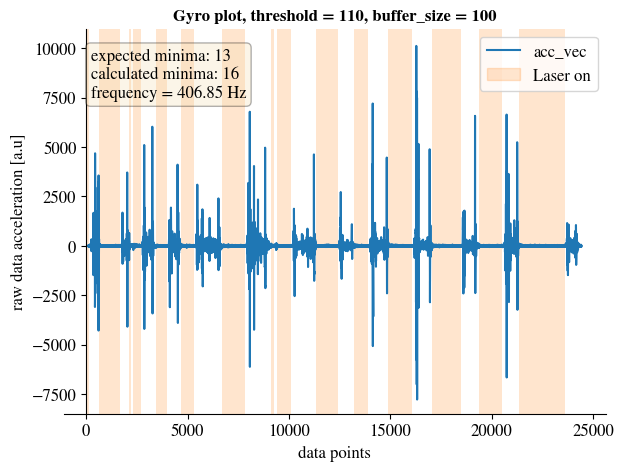

In [120]:
# plot the data 

fig, ax = plt.subplots(figsize=(7,5))

def plots():  

    ax.spines['left'].set_position('zero')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)    

    textstr = '\n'.join((
        r'expected minima: 13',
        r'calculated minima: %.2d' % (len(frames[0][2]), ),
        r'frequency = %.2f Hz' % (len(list(frames[0][1].index))/60,  )))
    
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=fs,
        verticalalignment='top', bbox=props)
    
    plt.plot(list(frames[0][1].index)[start:end], list(frames[0][1].acc_vec)[start:end], label = 'acc_vec')
    plt.fill_between([], [], color = 'C1', alpha = 0.2,label = 'Laser on')

    plt.ylim([-8500,11000])
    ax.set_title(f"Gyro plot, threshold = {threshold}, buffer_size = {bs}", fontsize=fs, weight='bold')
    ax.set(xlabel = r'data points', ylabel = r'raw data acceleration [a.u]')

    ax.legend(loc="upper right")
    sns.despine()

plots()

for i in range(len(frames[0][3])):
    start_on = frames[0][3]
    end_on = frames[0][4]
    ax.add_patch(patches.Rectangle((start_on[i], -10000), end_on[i]-start_on[i], 25500, linewidth=0,  color='C1', alpha=0.2))

# name_file = f"Gyro_threshold_{threshold}_file_{file_index}"
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.pdf")
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.png")



1043


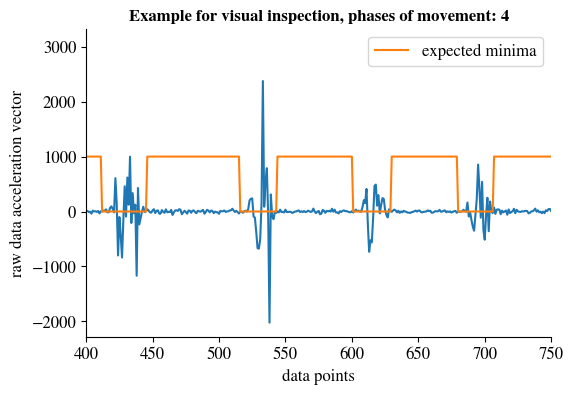

In [43]:
# example plot for minima bestimmung
fig, ax = plt.subplots(figsize=(6,4))

def plots():  
    print(len(list(frames[0][1].index)))  
    plt.plot(list(frames[0][1].index), list(frames[0][1].acc_vec))
    plt.plot(list(frames[0][1].index), list(frames[0][1].laser), label = 'expected minima')

    ax.set_title(f"Example for visual inspection, phases of movement: 4", fontsize=fs, weight='bold')
    ax.set(xlabel = r'data points', ylabel = r'raw data acceleration vector')

    ax.legend(loc="upper right")
    sns.despine()

    #ax.set_ylim(-200,200)
    plt.xlim(400,750)

plots()

name_file = f"gyro_example_visual_inspection"
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.pdf")
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.png")

